In [1]:
%matplotlib inline
import os

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import skimage as sk
import skimage.io as skio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils, models

In [2]:
SAVE = True
SEED = 321
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
OUTDIR = "out/"
DATADIR = "data/"
STYLEDIR = "style/"
CONTDIR = "content/"
assert all([os.path.isdir(x) for x in [OUTDIR, DATADIR, DATADIR + STYLEDIR, DATADIR + CONTDIR]])

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DTYPE = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [5]:
def imopen(fname, asfloat=True, **kwargs):
    def extract_fname(fname):
        fname = os.path.basename(fname) # remove path
        split = fname.split(".")
        return ".".join(split[:-1 if len(split) > 1 else None])
        
    fin = skio.imread(DATADIR + fname, **kwargs)
    if asfloat: fin = sk.img_as_float(fin)
    if len(fin.shape) == 3 and fin.shape[2] == 4: fin = fin[:,:,:3] # remove alpha channel (i.e. gifs)
    return fin, extract_fname(fname)


def tensor2img(tensor: torch.Tensor) -> np.ndarray:
    assert isinstance(tensor, torch.Tensor), f"Expected torch.Tensor, got {type(tensor)}"
    img = tensor.detach().cpu().numpy()
    if len(img.shape) == 4: img = img[0, :, :, :] # trim batch dimension
    img = np.transpose(img, (1, 2, 0)) # Color channel first -> color channel last
    return img


def img2tensor(img) -> torch.Tensor:
    assert isinstance(img, np.ndarray), f"Expected np.ndarray, got {type(img)}"
    # img = np.transpose(img, (2, 0, 1)) # Color channel last -> color channel first
    # return torch.from_numpy(img).unsqueeze(0).type(DTYPE)
    return transforms.ToTensor()(img).unsqueeze(0).type(DTYPE)
    

def imshow(img, display=False, gray=False, axis=False, title=None, **kwargs):
    if gray or len(img.shape) == 2: kwargs["cmap"] = cm.gray        
    if not axis:
        plt.axis("off")
        plt.tight_layout()
    if isinstance(img, torch.Tensor): img = tensor2img(img)
    plt.imshow(img, **kwargs)
    if title: plt.title(title)
    if display: plt.show()


def save(name, axis=False, **kwargs):
    if not SAVE: return
    if not axis:
        plt.axis("off")
        plt.tight_layout()
    plt.savefig(f"{OUTDIR}{name}", bbox_inches="tight", transparent="True", pad_inches=0, **kwargs)
    print(f"Saved {name}")

In [6]:
# SHAPE = (224,224)
# MAX_SIZE = 224
MAX_SIZE = 350
# MAX_SIZE = 512

# tfs = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


def imload(fname, resize=None, rot=False):
    img, fn = imopen(fname)
    if rot:
        img = sk.transform.rotate(img, 270, resize=True)

    # img = tfs(img)
    img = img2tensor(img)

    if resize is None:
        h, w = img.shape[-2:]
        if h > MAX_SIZE or w > MAX_SIZE:
            if h>w:
                w = int(MAX_SIZE * w / h)
                h = MAX_SIZE
            else:
                h = int(MAX_SIZE * h / w)
                w = MAX_SIZE
            resize = (h,w)
    if resize is not None:
        img = F.interpolate(img, size=resize, mode="bilinear", align_corners=False, antialias=True).squeeze(0)

    img = torch.autograd.Variable(img).unsqueeze(0)
    return img.type(DTYPE), fn

In [37]:
# ===================== #
# im_content, fn_content = imload(CONTDIR + "hearst.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "the_scream.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR + "soda-w.jpeg")
# im_style,   fn_style   = imload(STYLEDIR + "sf.jpg", resize=im_content.shape[-2:], rot=True)
# ===================== #
# im_content, fn_content = imload(CONTDIR + "soda-sw.jpeg")
# im_style,   fn_style   = imload(STYLEDIR + "sf.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR + "camp.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "wave.jpg", resize=im_content.shape[-2:], rot=True)
# im_style,   fn_style   = imload(STYLEDIR + "rain_princess.jpg", resize=im_content.shape[-2:])
# im_style,   fn_style   = imload(STYLEDIR + "seated-nude.jpg", resize=im_content.shape[-2:])
# ===================== #
im_content, fn_content = imload(CONTDIR + "germany.jpg")
im_style,   fn_style   = imload(STYLEDIR + "starry_night.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR + "greek0.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "udnie.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR  + "evans.jpg")
# im_content, fn_content = imload(CONTDIR  + "sf.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "seated-nude.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR  + "build.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "the_shipwreck_of_the_minotaur.jpg", resize=im_content.shape[-2:])
# ===================== #
# im_content, fn_content = imload(CONTDIR + "stone.jpg")
# im_content, fn_content = imload(CONTDIR + "lake.jpg")
# im_content, fn_content = imload(CONTDIR + "dancing.jpg")
# im_style,   fn_style   = imload(STYLEDIR + "wheatfields.jpeg", resize=im_content.shape[-2:])


print(im_style.shape, im_content.shape)
print(fn_style, fn_content)
assert im_style.shape == im_content.shape

torch.Size([1, 3, 262, 350]) torch.Size([1, 3, 262, 350])
starry_night germany


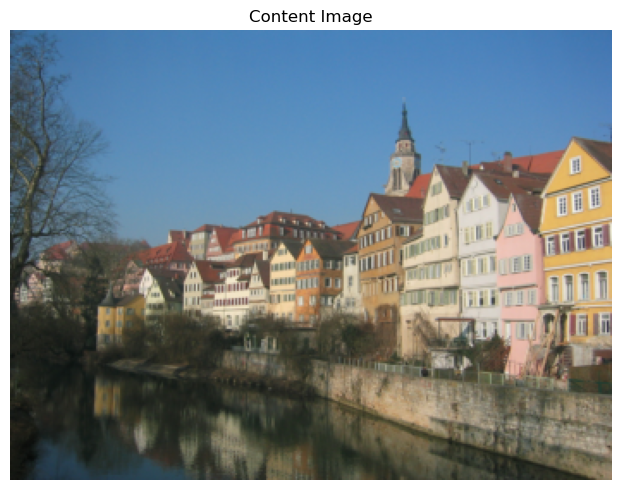

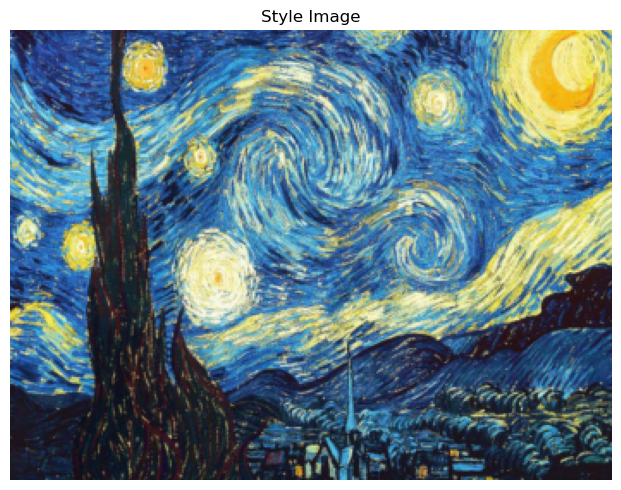

In [38]:
imshow(im_content, title="Content Image")
plt.show()
imshow(im_style, title="Style Image")
plt.show()

In [39]:
class Loss(nn.Module):
    def backward(self):
        self.loss.backward(retain_graph=True)
        return self.loss

class GramMatrix(nn.Module):
    def forward(self, img):
        a, b, c, d = img.size()  
        # batch, features, height, width
        features = img.view(a * b, c * d)
        G = torch.mm(features, features.T)
        return G.div(a * b * c * d)

class StyleLoss(Loss):
    def __init__(self, img, weight):
        super().__init__()
        self.gram = GramMatrix()
        self.img = self.gram.forward(img).detach() * weight
        self.weight = weight
        self.crit = nn.MSELoss(reduction='sum')
        # self.crit = nn.L1Loss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram.forward(input).mul(self.weight)
        self.loss = self.crit.forward(self.G, self.img)
        return self.output

class ContentLoss(Loss):
    def __init__(self, img, weight):
        super().__init__()
        self.img = img.detach() * weight
        self.weight = weight
        # self.crit = nn.MSELoss(reduction='sum')
        self.crit = nn.MSELoss(reduction='mean')
        # self.crit = nn.L1Loss()

    def forward(self, input):
        self.loss = self.crit.forward(input * self.weight, self.img)
        return input

In [40]:
class ImageNetNormalize(nn.Module):
    def forward(self, input):
        tfs = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        return tfs(input)

In [41]:
def total_variation(x: torch.Tensor):
    return torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))

In [58]:
# content and style weight (alpha and beta)
# alpha = 1e0
alpha = 3e0
# alpha = 1e1
# alpha = 3e1

"""more content"""
# beta = 1e2
beta = 1e3
# beta = 1e4
# beta = 1e5
# beta = 1e6
# beta = 1e8
# beta = 1e10
"""more style""" 

r = alpha/beta
r_txt = f"{r:0.0e}".replace("0", "")
print(r_txt)

3e-3


In [50]:
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(DEVICE)

In [51]:
# style_losses, content_losses = [], []
# model = nn.Sequential(ImageNetNormalize()).to(DEVICE) 

# content_layers = ['conv_4']
# style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# number = 1
# # for layer in list(vgg):
# for layer in vgg.children():
#     if isinstance(layer, nn.MaxPool2d):
#         name = f"pool_{number}"
#         layer = nn.AvgPool2d(layer.kernel_size, layer.stride, layer.padding)
#     elif isinstance(layer, nn.Conv2d):
#         name = f"conv_{number}"
#     elif isinstance(layer, nn.ReLU):
#         name = f"relu_{number}"
#         layer.inplace = False
#         number += 1
#     else:
#         continue

#     model.add_module(name, layer)

#     if name in style_layers:
#         lname = f"style_loss_{number}"
#         target = model.forward(im_style).clone()
#         loss = StyleLoss(target, beta)
#         style_losses.append(loss)
#         model.add_module(lname, loss)
#     if name in content_layers:
#         lname = f"content_loss_{number}"
#         target = model.forward(im_content).clone()
#         loss = ContentLoss(target, alpha)
#         content_losses.append(loss)
#         model.add_module(lname, loss)

In [52]:
style_losses, content_losses = [], []
model = nn.Sequential(ImageNetNormalize()).to(DEVICE) 

content_layers = ['conv4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

block, number = 1, 1
for layer in vgg.children():
    if isinstance(layer, nn.MaxPool2d):
        name = f'pool_{block}'
        layer = nn.AvgPool2d(layer.kernel_size, layer.stride, layer.padding)
        block += 1
        number = 1
    elif isinstance(layer, nn.Conv2d):
        name = f'conv{block}_{number}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu{block}_{number}'
        layer.inplace = False
        number += 1
    else:
        continue


    model.add_module(name, layer)

    if name in style_layers:
        lname = f"style_loss_{block}"
        target = model.forward(im_style).clone()
        loss = StyleLoss(target, beta)
        style_losses.append(loss)
        model.add_module(lname, loss)
    if name in content_layers:
        lname = f"content_loss_{block}"
        target = model.forward(im_content).clone()
        loss = ContentLoss(target, alpha)
        content_losses.append(loss)
        model.add_module(lname, loss)
print(model)

Sequential(
  (0): ImageNetNormalize()
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (relu1_1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU()
  (pool_1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (relu2_1): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss(
    (gram): GramMatrix()
    (crit): MSELoss()
  )
  (relu3_1): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU()
  (co

torch.Size([1, 3, 262, 350])
torch.Size([1, 3, 262, 350])


/tmp/ipykernel_16976/2667460173.py:22: FutureWarning: `seed` is a deprecated argument name for `random_noise`. It will be removed in version 0.23. Please use `rng` instead.
  fout = sk.util.random_noise(fout, mode='gaussian', seed=SEED, clip=True, var=(scale/100))


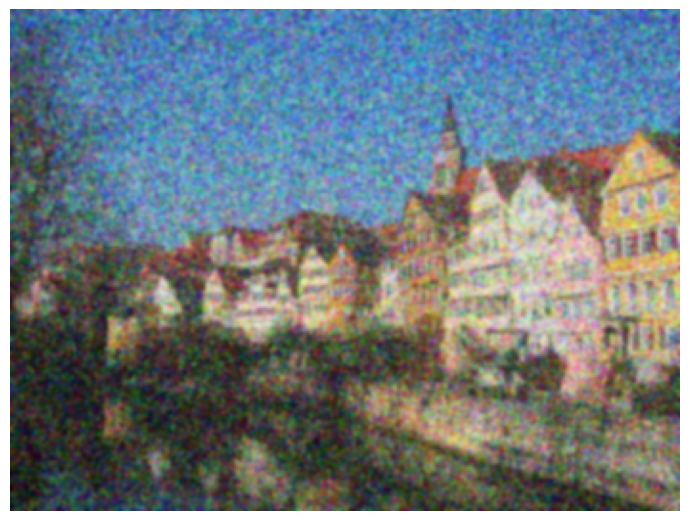

In [59]:
print(im_content.shape)

# scale = 100.0
# scale = 50.0
# scale = 33.0
# scale = 25.0
# scale = 10.0
scale = 5.0
# scale = 2.0
# scale = 1.0
# scale = 0.6
# scale = 0
assert abs(scale/100) <= 1


if True:
    copy = True
    fout = im_content.clone()

    fout = tensor2img(fout)
    # fout = sk.util.random_noise(fout, mode='speckle', seed=SEED, clip=True, var=(scale/100))
    fout = sk.util.random_noise(fout, mode='gaussian', seed=SEED, clip=True, var=(scale/100))
    fout = sk.filters.gaussian(fout, sigma=1, channel_axis=-1)
    fout = img2tensor(fout)
else:
    copy = False
    fout = torch.randn(im_content.size()) * (scale/100)  # scale noise down (less variance)

plt.figure(figsize=(7, 7))
imshow(fout)
print(fout.shape)

fout = nn.Parameter(fout.type(DTYPE))
optimizer = torch.optim.LBFGS([fout])
style_run, content_run, tv_run = [], [], []

In [60]:
frames=[]

In [61]:
# EPOCHS = 80
# EPOCHS = 40
EPOCHS = 20

run = [0]
while run[0] <= EPOCHS//2:
    def closure():
        fout.clamp(0, 1)

        optimizer.zero_grad()
        model.forward(fout)
        
        frame = tensor2img(fout.detach()).copy()
        frames.append(frame)
        
        style_err   = sum([s.backward() for s in style_losses])
        content_err = sum([c.backward() for c in content_losses])

        tv_loss = 0
        # tv_loss = total_variation(fout)

        # style_run.append(style_err)
        style_run.append(style_err.item())
        # content_run.append(content_err)
        content_run.append(content_err.item())
        if run[0] % (EPOCHS//10) == 0:
            print(f"|| {str(run[0]).zfill(len(str(EPOCHS)))}/{EPOCHS} || style: {style_err:0.2e} || content: {content_err:0.2e} || tv: {tv_loss:0.2e} ||")
            # imshow(frame)

        run[0]+=1
        return content_err + style_err + tv_loss

    optimizer.step(closure)
fout.clamp(0, 1);

|| 00/20 || style: 3.81e+05 || content: 4.89e+01 || tv: 0.00e+00 ||
|| 02/20 || style: 3.75e+05 || content: 5.28e+01 || tv: 0.00e+00 ||
|| 04/20 || style: 7.21e+04 || content: 5.65e+01 || tv: 0.00e+00 ||
|| 06/20 || style: 3.73e+04 || content: 6.39e+01 || tv: 0.00e+00 ||
|| 08/20 || style: 2.21e+04 || content: 6.39e+01 || tv: 0.00e+00 ||
|| 10/20 || style: 1.46e+04 || content: 6.59e+01 || tv: 0.00e+00 ||
|| 12/20 || style: 1.04e+04 || content: 6.67e+01 || tv: 0.00e+00 ||
|| 14/20 || style: 9.03e+03 || content: 7.15e+01 || tv: 0.00e+00 ||
|| 16/20 || style: 6.84e+03 || content: 6.92e+01 || tv: 0.00e+00 ||
|| 18/20 || style: 6.05e+03 || content: 6.99e+01 || tv: 0.00e+00 ||


In [62]:
fname = f"{'' if copy is None else 'copy'}_{int(scale)}_{fn_content}-{fn_style}-{r_txt}-E{len(style_run)}"
print(fname)

copy_5_germany-starry_night-3e-3-E20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


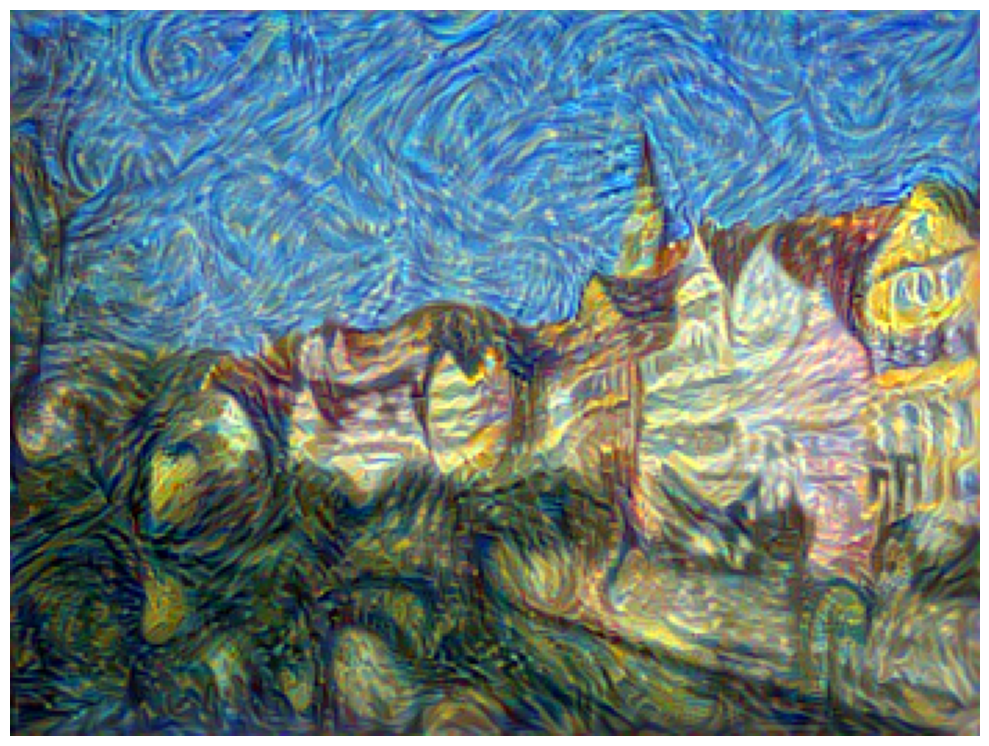

In [63]:
img_out = tensor2img(fout)
plt.figure(figsize=(10, 8))
imshow(img_out)
# save(fname+'.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Video created successfully.


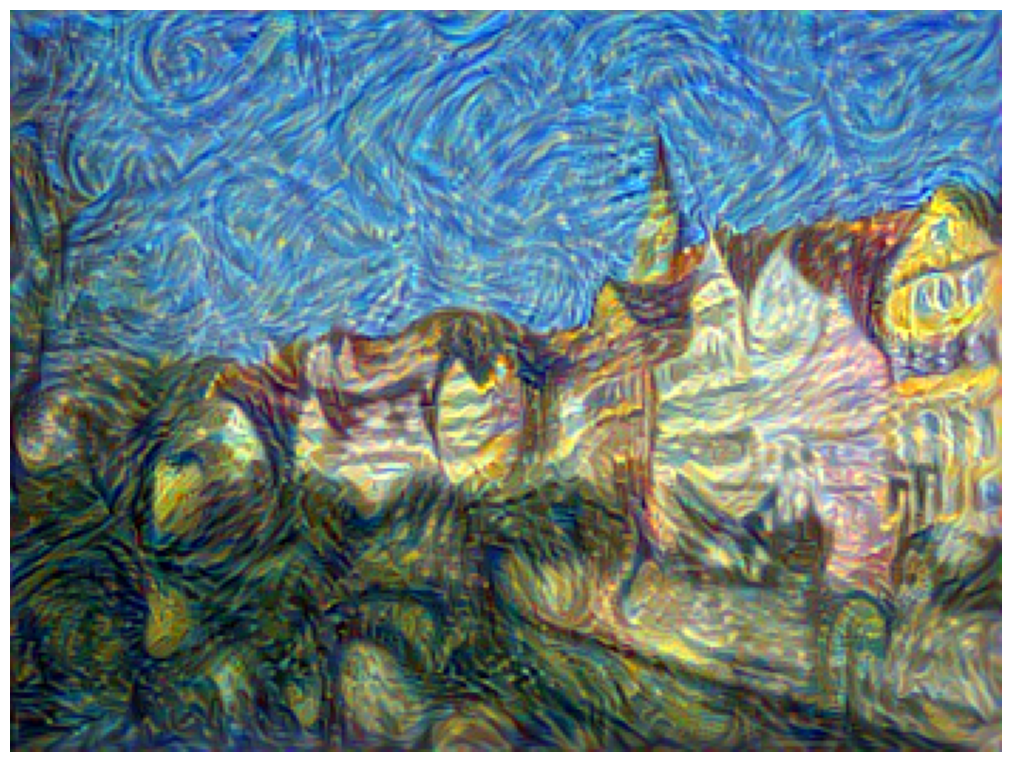

In [64]:
from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=10)  
writer = FFMpegWriter(fps=5)  

fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
# fig, ax = plt.subplots(figsize=(5, 7), constrained_layout=True)
ax.axis('off') 

with writer.saving(fig, f"{fname}.gif", dpi=100):
# with writer.saving(fig, f"{fname}.gif", dpi=200):
    for img in frames:
        ax.imshow(img)
        writer.grab_frame()

print("Video created successfully.")

Saved graphs/copy_50_hearst-the_scream-1e-4-E20_l.png


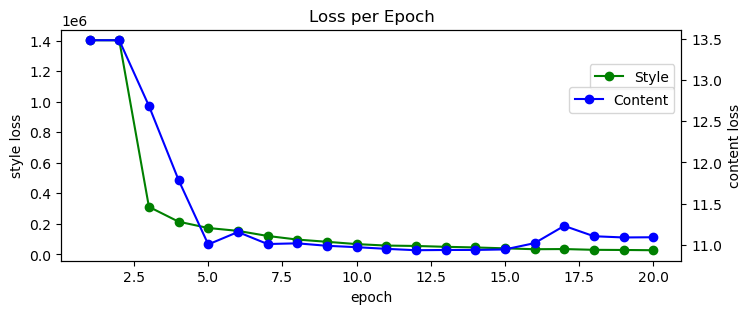

In [63]:
plt.figure(figsize=(8,3))
plt.title(f"Loss per Epoch")
ax1 = plt.subplot()
s = [s/beta for s in style_run]
c = [c/alpha for c in content_run]
line1 = ax1.plot(range(1, 1+len(s)), s, color='g', label='Style', marker='o')
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, 1+len(c)), c, color='b', label='Content', marker='o')

ax1.legend(loc=1, bbox_to_anchor=(1, 0.88))
ax2.legend(loc=1, bbox_to_anchor=(1, 0.78))

ax1.set_xlabel('epoch')
ax1.set_ylabel('style loss')
ax2.set_ylabel('content loss')
save('graphs/'+ fname + '_l.png', axis=True)